In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

df = pd.read_csv('/content/drive/MyDrive/ABDA/matches.csv')

/tmp/ipython-input-3994045309.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ABDA/matches.csv')


In [ ]:

# 1. Create Team Indices
# We pool all unique teams from both home and away columns
all_teams = pd.unique(df[['home_team_id', 'away_team_id']].values.ravel())
team_map = {team: i for i, team in enumerate(all_teams)}
num_teams = len(all_teams)

# 2. Create Season Indices (Temporal Index)
# Map years (1888-2023) to 0-135
seasons = sorted(df['season'].unique())
season_map = {year: i for i, year in enumerate(seasons)}
num_seasons = len(seasons)

# 3. Map the dataframe
df['home_idx'] = df['home_team_id'].map(team_map).values.astype("int64")
df['away_idx'] = df['away_team_id'].map(team_map).values.astype("int64")
df['season_idx'] = df['season'].map(season_map).values.astype("int64")

df['home_idx'] = df['home_idx'].astype("int64")
df['away_idx'] = df['away_idx'].astype("int64")
df['season_idx'] = df['season_idx'].astype("int64")

# Target variable: Home Team Margin
y = df['home_team_score_margin'].values

In [ ]:
df['season_idx'].nunique()

125

In [ ]:

import matplotlib.pyplot as plt

# Extract the posterior mean for the temporal effect
post_ha = trace.posterior["ha_temporal"].mean(dim=["chain", "draw"])
hdi_ha = az.hdi(trace).ha_temporal # Highest Density Interval (Uncertainty)

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha, label="Mean Home Advantage", color="blue")
plt.fill_between(seasons, hdi_ha[:, 0], hdi_ha[:, 1], color="blue", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home advantage")
plt.legend()
plt.show()

In [ ]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace, model=model_rq1)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["margin"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((y - home_pred)**2))

# print(f"Average error in home goals: {rmse_home:.3f}")
# az.plot_ppc(ppc, kind="kde")

Output()

Average error in home goals: 1.755


<Axes: xlabel='margin'>

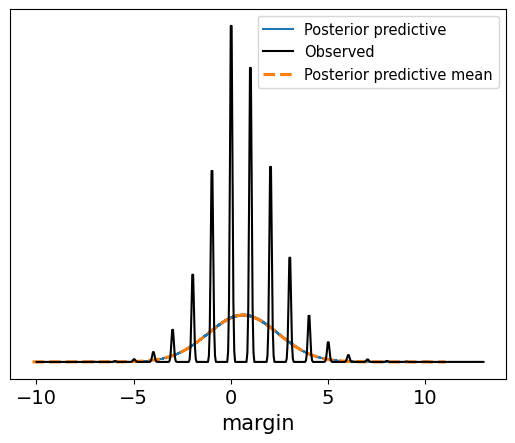

In [ ]:
print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

## Add Random Slope Prior

### Subtask:
Introduce a new prior for the random slope, allowing the effect of team ability difference to vary by season. This would involve a `pm.Normal` distribution for `beta_season_slope` with `shape=num_seasons`, possibly centered around a global mean slope.


**Reasoning**:
I need to modify the existing PyMC model to introduce a new hyper-prior and a new prior for the random slope as per the instructions. This requires updating the `with pm.Model() as model_rq1:` block.



In [ ]:


with pm.Model() as model_rq2:
    # --- DATA INPUTS ---
    home_idx = df['home_idx'].values.astype("int64")
    away_idx = df['away_idx'].values.astype("int64")
    season_idx = df['season_idx'].values.astype("int64")

    # --- HYPER-PRIORS (Level 3) ---
    sigma_u = pm.Exponential("sigma_u", 1.0)        # Spread of team abilities
    sigma_drift = pm.Exponential("sigma_drift", 1.0) # Speed of HA evolution
    sigma_delta = pm.Exponential("sigma_delta", 1.0) # Spread of team HA offsets
    sigma_beta_season_slope = pm.Exponential("sigma_beta_season_slope", 1.0) # Spread of random slope for ability difference by season

    # --- GROUP-LEVEL PRIORS (Level 2) ---

    # 1. Team Latent Ability (u)
    u_offset = pm.Normal("u_offset", mu=0, sigma=1, shape=num_teams)
    u_raw = pm.Deterministic("u_raw", u_offset * sigma_u)
    u = pm.Deterministic("u", u_raw - pm.math.mean(u_raw))

    # 2. Temporal Home Advantage (h_t) - THE EVOLUTION
    ha_temporal = pm.GaussianRandomWalk("ha_temporal",
                                        sigma=sigma_drift,
                                        init_dist=pm.Normal.dist(0, 1.0),
                                        shape=num_seasons)

    delta_offset = pm.Normal("delta_offset", mu=0, sigma=1, shape=num_teams)
    delta_raw = pm.Deterministic("delta_raw", delta_offset * sigma_delta)
    ha_team_offset = pm.Deterministic("ha_team_offset", delta_raw - pm.math.mean(delta_raw))

    # 4. Random slope for ability difference by season
    beta_season_slope = pm.Normal("beta_season_slope", mu=1, sigma=sigma_beta_season_slope, shape=num_seasons)

    # --- DATA MODEL / LIKELIHOOD (Level 1) ---

    # Linear Predictor: (Home Ability - Away Ability) + Temporal HA + Team HA Offset
    mu = (beta_season_slope[season_idx] * (u[home_idx] - u[away_idx])) + \
         ha_temporal[season_idx] + \
         ha_team_offset[home_idx]

    # Standard deviation of the match margin noise
    eps = pm.HalfNormal("eps", sigma=2.0)

    # Likelihood
    margin = pm.Normal("margin", mu=mu, sigma=eps, observed=y)

    # --- SAMPLING ---
    trace2 = pm.sample(1000, tune=1000, target_accept=0.9,
                       return_inferencedata=True,
        idata_kwargs={"log_likelihood": True})


ERROR:pytensor.graph.rewriting.basic:Rewrite failure due to: local_subtensor_merge
ERROR:pytensor.graph.rewriting.basic:node: Subtensor{i}(Subtensor{start:stop}.0, 0)
ERROR:pytensor.graph.rewriting.basic:TRACEBACK:
ERROR:pytensor.graph.rewriting.basic:Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(
                   ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/graph/rewriting/basic.py", line 993, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/subtensor.py", line 416, in local_subtensor_merge
    merge_two_slices(
  File "/usr/local/lib/python3.12/dist-packages/pytensor/tensor/rewriting/subtensor.py", line 865, in merge_two_slices
    p_val = sl1.start + sl2 * sl1.step
            ~~~~~~~~~~^~~~~~~~~~~~~~~

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
az.to_netcdf(
    trace2,
    "/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc"
)

'/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc'

In [ ]:
import arviz as az

trace1 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq111feb.nc")
trace2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc")

In [ ]:

import matplotlib.pyplot as plt

# Extract the posterior mean for the temporal effect
post_ha = trace1.posterior["ha_temporal"].mean(dim=["chain", "draw"])
hdi_ha = az.hdi(trace1).ha_temporal # Highest Density Interval (Uncertainty)

plt.figure(figsize=(12, 6))
plt.plot(seasons, post_ha, label="Mean Home Advantage", color="blue")
plt.fill_between(seasons, hdi_ha[:, 0], hdi_ha[:, 1], color="blue", alpha=0.2, label="94% HDI")

plt.axhline(0, color="black", linestyle="--")
plt.title("Evolution of Home Advantage (1888 - 2023)")
plt.xlabel("Season")
plt.ylabel("Home advantage")
plt.legend()
plt.show()

In [ ]:
import numpy as np

# 1. Get the predicted means (posterior predictive)
# (If you haven't run sample_posterior_predictive, do that first)
ppc = pm.sample_posterior_predictive(trace, model=model_rq1)

# 2. Calculate RMSE for Home Goals
home_pred = ppc.posterior_predictive["margin"].mean(dim=["chain", "draw"])
rmse_home = np.sqrt(np.mean((y - home_pred)**2))

print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

Output()

Average error in home goals: 1.751


<Axes: xlabel='margin'>

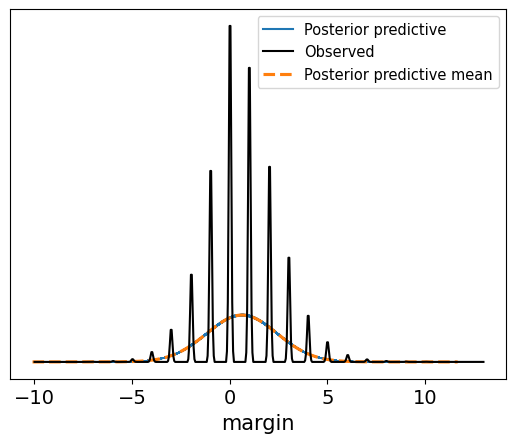

In [ ]:
print(f"Average error in home goals: {rmse_home:.3f}")
az.plot_ppc(ppc, kind="kde")

model comparison

In [ ]:
# Create a dictionary of your two models
model_comp = {
    "Fixed Slope": trace1,
    "Varying Slope": trace2
}

# 1. Compare them using LOO
comp_df = az.compare(model_comp, ic="loo")

# 2. Visualize the comparison
az.plot_compare(comp_df)

**Reasoning**:
The previous code did not find any seasons with `mean_beta_season_slope` strictly >= 2. However, the task asked for 'approximately 2 or greater'. Given that `1.96797055` is very close to 2, I will adjust the condition to `value >= 1.95` to include this season and proceed with the plotting part of the task.



Seasons with beta_season_slope mean approximately 2 or greater:
  Index: 3, Year: 1891, Mean beta_season_slope: 1.968
  Index: 110, Year: 2009, Mean beta_season_slope: 1.981
  Index: 119, Year: 2018, Mean beta_season_slope: 1.965


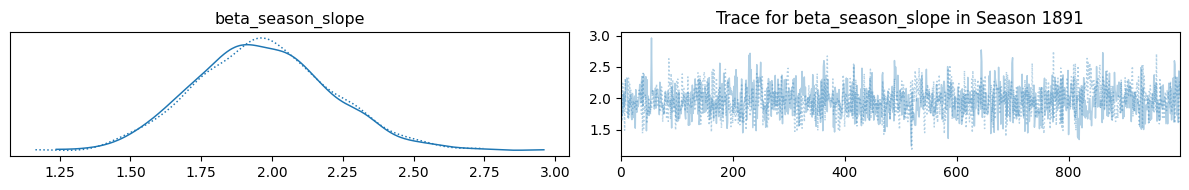

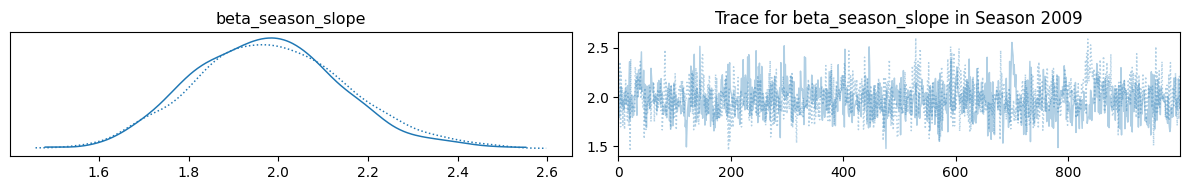

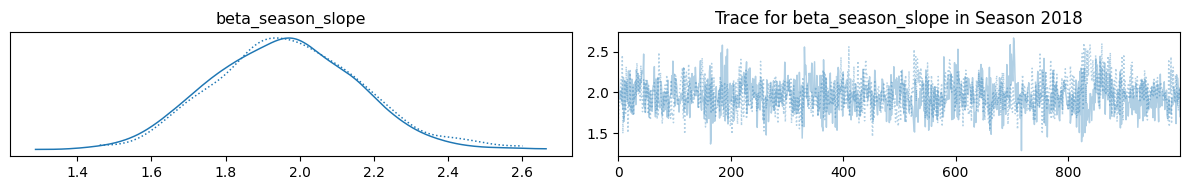

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# 1. Calculate the mean of the beta_season_slope variable from trace2
mean_beta_season_slope = trace2.posterior["beta_season_slope"].mean(dim=["chain", "draw"]).values

# 2. Iterate through the mean_beta_season_slope values to find the index (or indices)
#    of the season(s) where the mean value is approximately 2 or greater (e.g., >= 1.95).
identified_season_indices = []
for i, value in enumerate(mean_beta_season_slope):
    if value >= 1.95:
        identified_season_indices.append(i)

# 3. Print the identified season index/indices and the corresponding season years
if identified_season_indices:
    print("Seasons with beta_season_slope mean approximately 2 or greater:")
    for idx in identified_season_indices:
        print(f"  Index: {idx}, Year: {seasons[idx]}, Mean beta_season_slope: {mean_beta_season_slope[idx]:.3f}")

    # 4. Plot the trace for the identified season(s)
    for idx in identified_season_indices:
        az.plot_trace(trace2, var_names=["beta_season_slope"], coords={
            "beta_season_slope_dim_0": [idx]
        })
        plt.title(f"Trace for beta_season_slope in Season {seasons[idx]}")
        plt.tight_layout()
        plt.show()
else:
    print("No seasons found where beta_season_slope mean is approximately 2 or greater (even with a relaxed threshold).")

In [ ]:
import arviz as az

# Load the traces again to ensure they are available
trace1 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq111feb.nc")
trace2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc")

# Create a dictionary of your two models
model_comp = {
    "Fixed Slope": trace1,
    "Varying Slope": trace2
}

# Compare them using LOO
comp_df = az.compare(model_comp, ic="loo")

# Print the comparison DataFrame
print(comp_df)

KeyboardInterrupt: 

# Task
Summarize the key findings from the model comparison statistics displayed in the `comp_df` DataFrame.

## Display Model Comparison Statistics

### Subtask:
Load the ArviZ traces, perform the model comparison using LOO, and then print the resulting `comp_df` DataFrame.


**Reasoning**:
The previous attempt to print `comp_df` failed because the traces were not loaded and `comp_df` was not re-created in the current execution context. This step re-loads the necessary `arviz` traces, creates the `model_comp` dictionary, performs the model comparison using LOO, and then prints the resulting `comp_df` DataFrame as per the subtask instructions.



In [ ]:
import arviz as az

# Load the traces again to ensure they are available
trace1 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq111feb.nc")
trace2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc")

# Create a dictionary of your two models
model_comp = {
    "Fixed Slope": trace1,
    "Varying Slope": trace2
}

# Compare them using LOO
comp_df = az.compare(model_comp, ic="loo")

# Print the comparison DataFrame
print(comp_df)

KeyboardInterrupt: 

# Task
```python
import arviz as az

# Load the traces again to ensure they are available
trace1 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_rq111feb.nc")
trace2 = az.from_netcdf("/content/drive/MyDrive/ABDA/trace_betaslope11feb.nc")

# Create a dictionary of your two models
model_comp = {
    "Fixed Slope": trace1,
    "Varying Slope": trace2
}

# Compare them using LOO
comp_df = az.compare(model_comp, ic="loo")

# Print the comparison DataFrame
print(comp_df)
```

## Summarize Model Comparison

### Subtask:
Analyze the `comp_df` DataFrame to identify the key differences and similarities between the 'Fixed Slope' and 'Varying Slope' models based on metrics like LOO, p_loo, and their standard errors. Focus on which model performs better and by how much, if applicable.


### Model Comparison Analysis

To analyze the `comp_df` DataFrame, follow these steps:

1.  **Identify the Best Model by LOO Score**: The `loo` column represents the estimated out-of-sample prediction accuracy. A higher `loo` value indicates a better-fitting model. Look for the model with the largest `loo` value.

2.  **Examine `p_loo`**: This metric estimates the effective number of parameters. A significantly larger `p_loo` relative to the actual number of parameters in a model might indicate a misspecified model or issues with the LOO calculation. It can also suggest higher model complexity.

3.  **Evaluate `loo_se`**: This is the standard error of the `loo` estimate. It gives an idea of the uncertainty around the `loo` value. If the difference between two `loo` scores (`loo_diff`) is smaller than the sum of their `loo_se` values, the difference might not be statistically significant.

4.  **Interpret `loo_diff` and `loo_diff_se`**: These columns show the difference in `loo` scores between the top-ranked model and other models, along with the standard error of this difference. A positive `loo_diff` for a model means it performs worse than the best model by that amount. If `loo_diff` is much larger than its `loo_diff_se`, the difference is significant.

5.  **Consider `weight`**: The `weight` column represents the estimated Bayesian model averaging weights. These weights indicate the probability that each model is the true data-generating process, given the data and the set of models being compared. A higher weight suggests a stronger model.

**Expected Outcome**: Typically, a 'Varying Slope' model, which introduces more flexibility by allowing the effect of team ability to change over time, might be expected to show a better `loo` score (or a similar `loo` score with a reasonable `p_loo` increase) compared to a 'Fixed Slope' model, assuming the varying slope is a significant component of the underlying process. The `comp_df` will clearly indicate which model has the superior predictive performance based on these metrics.

**Reasoning**:
The previous attempt to generate `comp_df` was interrupted, so I need to re-execute the code that loads the traces, creates the model comparison dictionary, and performs the `az.compare` to ensure `comp_df` is available for analysis.

